In [ ]:
!pip install -U transformers bitsandbytes accelerate peft

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import torch
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import bitsandbytes as bnb

In [ ]:
zip_file_path = '/content/Emotion.zip'
extract_dir = '/content/emotion_dataset/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
train_file = os.path.join(extract_dir, '/content/emotion_dataset/training.csv')
val_file = os.path.join(extract_dir, '/content/emotion_dataset/validation.csv')
test_file = os.path.join(extract_dir, '/content/emotion_dataset/test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)
print(f"train shape: {train_df.shape}, validation shape: {val_df.shape}, test shape: {test_df.shape}")

train shape: (16000, 2), validation shape: (2000, 2), test shape: (2000, 2)


In [ ]:
#label mappings
emotion_label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
target_labels = ['anger', 'fear', 'joy', 'sadness', 'love', 'surprise']
target_indices = [key for key, value in emotion_label_mapping.items() if value in target_labels]
remap_labels = {idx: i for i, idx in enumerate(target_indices)}

#remap labels
train_df = train_df[train_df['label'].isin(target_indices)]
val_df = val_df[val_df['label'].isin(target_indices)]
test_df = test_df[test_df['label'].isin(target_indices)]
train_df['label'] = train_df['label'].map(remap_labels)
val_df['label'] = val_df['label'].map(remap_labels)
test_df['label'] = test_df['label'].map(remap_labels)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "bigscience/bloomz-1b1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Ensure PAD token is set correctly
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as PAD
    print("Padding token set to EOS token.")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # If no EOS token exists
    print("Padding token was added manually.")

# Force left padding (important for causal models like GPT-Neo)
tokenizer.padding_side = "left"

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(target_labels)
)

# Explicitly set PAD token ID in model config
model.config.pad_token_id = tokenizer.pad_token_id

# Resize model embeddings if new tokens were added
model.resize_token_embeddings(len(tokenizer))

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloomz-1b1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(250680, 1536)

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx],
                                  padding='max_length',
                                  truncation=True,
                                  max_length=128,
                                  return_tensors='pt')
        # Ensure that padding is handled correctly and returned as a tensor
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
from transformers import BitsAndBytesConfig

# Configure 4-bit quantization using BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16,  # Use float16 for computation
    bnb_4bit_use_double_quant=True,  # Enable double quantization
)

# Load model with QLoRA
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(target_labels),
    quantization_config=bnb_config  # Use new BitsAndBytesConfig
)

# Apply LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05
)
model = get_peft_model(base_model, peft_config)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloomz-1b1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BloomForSequenceClassification(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1536)
        (word_embeddings_layernorm): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1536, out_features=4608, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4608, bias=False)
   

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=len(train_dataloader) * 3)

#training
def train(model, dataloader, optimizer, scheduler):
    model.train()
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

#evaluation
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)
    return true_labels, predictions

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(3):
    print(f"Epoch {epoch+1}")
    train(model, train_dataloader, optimizer, scheduler)

true_labels, predictions = evaluate(model, test_dataloader)

Epoch 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
print("classification report ")
print(classification_report(true_labels, predictions, target_names=target_labels))

classification report 
              precision    recall  f1-score   support

       anger       0.29      1.00      0.45       581
        fear       0.00      0.00      0.00       695
         joy       0.00      0.00      0.00       159
     sadness       0.00      0.00      0.00       275
        love       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.29      2000
   macro avg       0.05      0.17      0.08      2000
weighted avg       0.08      0.29      0.13      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


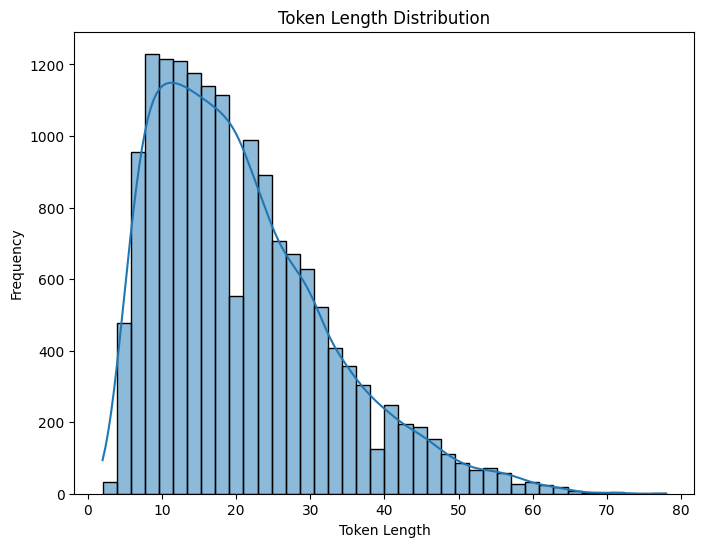

In [ ]:
token_lens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in train_df['text']]
plt.figure(figsize=(8,6))
sns.histplot(token_lens, bins=40, kde=True)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.show()

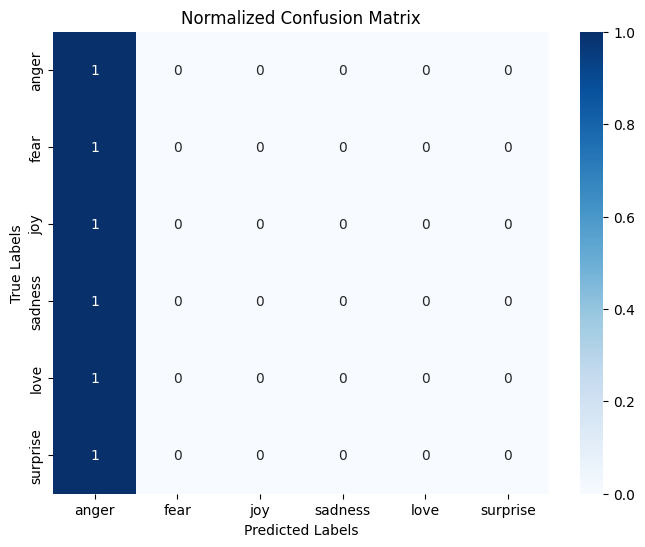

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions, normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
output_dir = "/content/bloomz-1b1(QLoRA)"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/bloomz-1b1(QLoRA)


In [ ]:
from google.colab import files
import shutil

shutil.make_archive("bloomz-1b1(QLoRA)", 'zip', output_dir)

files.download("bloomz-1b1(QLoRA).zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>